In [224]:
# python version - 3.7.4
# jupyter lab version - 1.1.4
# os - windows 10 home 1909 version
import pandas as pd # version - 0.25.1
import numpy as np # version - 1.16.5
import requests # version - 2.22.0
import pymongo # version - 2.8.1
from datetime import datetime
import scrapy
import os
import json

In [3]:
# pandas 사이즈 조정
pd.set_option('display.max_row', 300)
pd.set_option('display.max_column', 100)

In [23]:
!tree bithumb /f

bithumb
├── bithumb
│   ├── __init__.py
│   ├── __pycache__
│   │   ├── __init__.cpython-36.pyc
│   │   ├── __init__.cpython-37.pyc
│   │   ├── items.cpython-36.pyc
│   │   ├── mongodb.cpython-36.pyc
│   │   ├── pipelines.cpython-36.pyc
│   │   ├── settings.cpython-36.pyc
│   │   └── settings.cpython-37.pyc
│   ├── items.py
│   ├── middlewares.py
│   ├── mongodb.py
│   ├── pipelines.py
│   ├── settings.py
│   └── spiders
│       ├── __init__.py
│       ├── __pycache__
│       │   ├── __init__.cpython-36.pyc
│       │   ├── __init__.cpython-37.pyc
│       │   ├── bithumb.cpython-36.pyc
│       │   └── bithumb.cpython-37.pyc
│       └── bithumb.py
└── scrapy.cfg
/f [error opening dir]

4 directories, 20 files


In [ ]:
## scrapy로 만들어보기
# !scrapy startproject bithumb

In [24]:
# items.py 수정
!cat bithumb/bithumb/items.py

import scrapy

class BithumbItem(scrapy.Item):
    date = scrapy.Field()
    coin_names = scrapy.Field()
    coin_codes = scrapy.Field()
    coin_prices = scrapy.Field()
    price_changes = scrapy.Field()
    transaction_volumes = scrapy.Field()
    market_capitalizations = scrapy.Field()


In [29]:
%%writefile bithumb/bithumb/items.py
import scrapy

class BithumbItem(scrapy.Item):
    date = scrapy.Field()
    coin_names = scrapy.Field()
    coin_codes = scrapy.Field()
    coin_prices = scrapy.Field()
    price_changes = scrapy.Field()
    transaction_volumes = scrapy.Field()
    market_capitalizations = scrapy.Field()

Overwriting bithumb/bithumb/items.py


In [30]:
# spiders 생성

In [70]:
%%writefile bithumb/bithumb/spiders/bithumb.py

# python version - 3.7.4
# jupyter lab version - 1.1.4
# os - windows 10 home 1909 version
import pandas as pd  # version - 0.25.1
import numpy as np  # version - 1.16.5
import requests  # version - 2.22.0
import pymongo  # version - 2.8.1
from bs4 import BeautifulSoup  # version - 4.8.0
from datetime import datetime
import scrapy
import os
import json
import scrapy
import time

from bithumb.items import BithumbItem

# 식별자 변수명은 지정된 변수명을 사용해야함


class Spider(scrapy.Spider):
    # 거래가 실시간으로 바뀌기 때문에 크롤링할때마다 연결해주어야함
    name = 'BithumbSpider'
    # 1. 웹페이지 연결
    allow_domain = ['https://www.bithumb.com/']
    start_urls = ['https://www.bithumb.com/']

    def __init__(self, highprice, lowprice, name, *args, **kwargs):
        self.highprice = highprice
        self.lowprice = lowprice
        self.name = name
        super(Spider, self).__init__(*args, **kwargs)

    def parse(self, response):
        item = BithumbItem()
        # 실행시간 확인
        date = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime(time.time()))

        # 3. 코인 이름 가져오기
        selector = '//*[@id="sise_list"]/tbody/tr/td[1]/p/a/strong/text()'
        coin_names = response.xpath(selector).extract()

        # 4. 코인 코드 가져오기
        selector = '//*[@id="sise_list"]/tbody/tr/td[1]/p/a/span/text()'
        coin_codes = response.xpath(selector).extract()

        # 5. 전체 가격가져오기
        selector = '/html/body/div[2]/section/div[1]/div[4]/table/tbody/tr/td[2]/strong/text()'
        coin_prices = response.xpath(selector).extract()

        # 6. 변동률 가져오기 (전일 대비)
        selector = '/html/body/div[2]/section/div[1]/div[4]/table/tbody/tr/td[3]/div/strong/text()'
        price_changes = response.xpath(selector).extract()

        # 7. 거래량 가져오기(24th, 단위 백만)
        selector = '/html/body/div[2]/section/div[1]/div[4]/table/tbody/tr/td[4]/span/text()'
        transaction_volumes = response.xpath(selector).extract()

        # 8. 시가총액 가져오기(단위 억)
        selector = '/html/body/div[2]/section/div[1]/div[4]/table/tbody/tr/td[5]/strong/text()'
        market_capitalizations = response.xpath(selector).extract()

        # 9. 리스트 데이터 정리
        for item in zip(date, coin_names, coin_codes, coin_prices, price_changes,
                        transaction_volumes, market_capitalizations):
            item = {
                'date': date,
                'coin_names': item[1].strip(),
                'coin_codes': item[2].strip(),
                'coin_prices': item[3].replace('원', '').replace(',', '').strip(),
                'price_changes': item[4].replace('원', '').replace(',', '').strip(),
                'transaction_volumes': item[5].replace('원', '').replace('≈', '').replace(',', '').strip()[:-6],
                'market_capitalizations': item[6].replace('조', '').replace('억', '').replace(' ', ''),
            }
            yield item

Overwriting bithumb/bithumb/spiders/bithumb.py


In [ ]:
# 6. pipeline.py 생성
# 몽고디비에 저장
# collection 생성

In [225]:
%%writefile bithumb/bithumb/mongodb.py
import pymongo

client = pymongo.MongoClient('mongodb://{id}:{pw}@{ip}:27017')
# db 생성
db = client.bithumb

# 컬렉션 생성
collection = db.coins

Overwriting bithumb/bithumb/mongodb.py


In [ ]:
# pipelines 수정

In [226]:
%%writefile bithumb/bithumb/pipelines.py

# -*- coding: utf-8 -*-

# Define your item pipelines here
#
# Don't forget to add your pipeline to the ITEM_PIPELINES setting
# See: https://docs.scrapy.org/en/latest/topics/item-pipeline.html


import json
import requests
from.mongodb import collection

class BithumbPipeline(object):
    
    # 생성자 함수
    def __init__(self):#,Spider):
        self.webhook_url = 'url'

    # 아규먼트 가져오기
    def open_spider(self, Spider):
        self.highprice = Spider.highprice
        self.lowprice = Spider.lowprice
        self.name = Spider.name
    
    # 슬랙메세지 전송
    def send_msg(self, msg):        
        payload = {
            'channel' : '#coin',
            'username' : 'coin_highrow_bot',
            'icon_emoji' : ':moneybag:',
            'text' : msg,
        }
        # webhook_url로 json.dumps 형태의 페이로드를 전송하는 코드
        requests.post(self.webhook_url, json.dumps(payload))
        time.sleep(1)
        
    # mongodb저장 및 슬랙전송 코드   
    def process_item(self, item, Spider):
         # 몽고디비에 저장하는 코드 추가
        data ={
            'date' : item['date'],
            'coin_names' : item['coin_names'],
            'coin_codes' : item['coin_codes'],
            'coin_prices' : item['coin_prices'],
            'price_changes' : item['price_changes'],
            'transaction_volumes' :item['transaction_volumes'],
            'market_capitalizations' : item['market_capitalizations'],
        }
        
        collection.insert(data)

        if float(self.highprice) < float(item['coin_prices']) and self.name == item['coin_names'] :
            self.send_msg(f"고가 알림 : {item['coin_names']} 가격은 {item['coin_prices']}원 입니다. 알림 설정 금액은 {self.highprice}원 입니다.")
            
        if float(self.lowprice) > float(item['coin_prices']) and self.name == item['coin_names'] :             
            self.send_msg(f"저가 알림 : {item['coin_names']} 가격은 {item['coin_prices']}원 입니다. 알림 설정 금액은 {self.lowprice}원 입니다.")
        
        return item

Overwriting bithumb/bithumb/pipelines.py


In [ ]:
# #권한 부여 run.sh
# !ls -al | grep run.sh
# os.chmod('run.sh', 0o764)
# !ls -al | grep run.sh
# robottxt 설정 변경
# # ROBOTSTXT_OBEY = True 를 False로 바꾸면 robotstxt를 안함
# ! cat bithumb/bithumb/settings.py

In [185]:
# settings.py에서 pipeline 사용 설정
# 쉘커맨드 사용하여
# setting.py에서 아래 내용 찾아서 그냥 주석 해제 시켜도됨

# ITEM_PIPELINES = {
#    'bithumb.pipelines.BithumbPipeline': 300,
# }

In [186]:
# 작동확인(local)

In [ ]:
# schell에서 sh run.sh 실행

In [15]:
%%writefile run.sh
cd bithumb
scrapy crawl BithumbSpider -a highprice=7300000 -a lowprice=6000000 -a name='비트코인'

Overwriting run.sh


In [ ]:
# 작동확인(server)

In [ ]:
%%writefile run.sh
cd /home/ubuntu/python3/notebook/99.project/crawlingproject/bithumb/bithumb
scrapy crawl BithumbSpider -a highprice=7300000 -a lowprice=6000000 -a name='비트코인'

In [ ]:
# 작동확인(server) 
!./run.sh

# Columns 설명
- date : 날짜
- coin_names : 한글 코인이름	
- coin_codes : 코인 코드
- coin_prices : 현재 코인 가격
- price_changes	: 변동률
- transaction_volumes : 거래량(24th, 백만단위)
- market_capitalizations : 시가총액(억 단위)

In [155]:
# 디비연결
# 데이터 프레임 생성
server = pymongo.MongoClient('mongodb://{id}:{pw}@{ip}:27017/')
coins = server.bithumb.coins
bitcoin = pd.DataFrame(list(coins.find({'coin_names':'비트코인'})))
bitcoin

,_id,date,coin_names,coin_codes,coin_prices,price_changes,transaction_volumes,market_capitalizations
0,5e6cb1b0e0858f2c714a23dd,2020-03-14-19:28:00,비트코인,BTC/KRW,6779000,-218000,154628,1169428
1,5e6cb846e0858f331615dac0,2020-03-14-19:56:06,비트코인,BTC/KRW,6833000,-164000,154301,1195979
2,5e6cbcd4e0858f3713db891a,2020-03-14-20:15:32,비트코인,BTC/KRW,6890000,-107000,152217,1206068
3,5e6cbcfde0858f372239a205,2020-03-14-20:16:13,비트코인,BTC/KRW,6886000,-111000,152256,1206068
4,5e6cbd17e0858f372c6aa642,2020-03-14-20:16:39,비트코인,BTC/KRW,6895000,-102000,152238,1206068
...,...,...,...,...,...,...,...,...
186,5e70ea70e0858f24bc2b4a9e,2020-03-18-00:19:12,비트코인,BTC/KRW,6619000,+55000,115559,1172028
187,5e70ea83e0858f24c4251be3,2020-03-18-00:19:31,비트코인,BTC/KRW,6621000,+57000,115639,1172028
188,5e70ecfae0858f25300b6dc5,2020-03-18-00:30:02,비트코인,BTC/KRW,6663000,+99000,114444,1173111
189,5e70f405e0858f25d0461625,2020-03-18-01:00:05,비트코인,BTC/KRW,6721000,+157000,112992,1178911


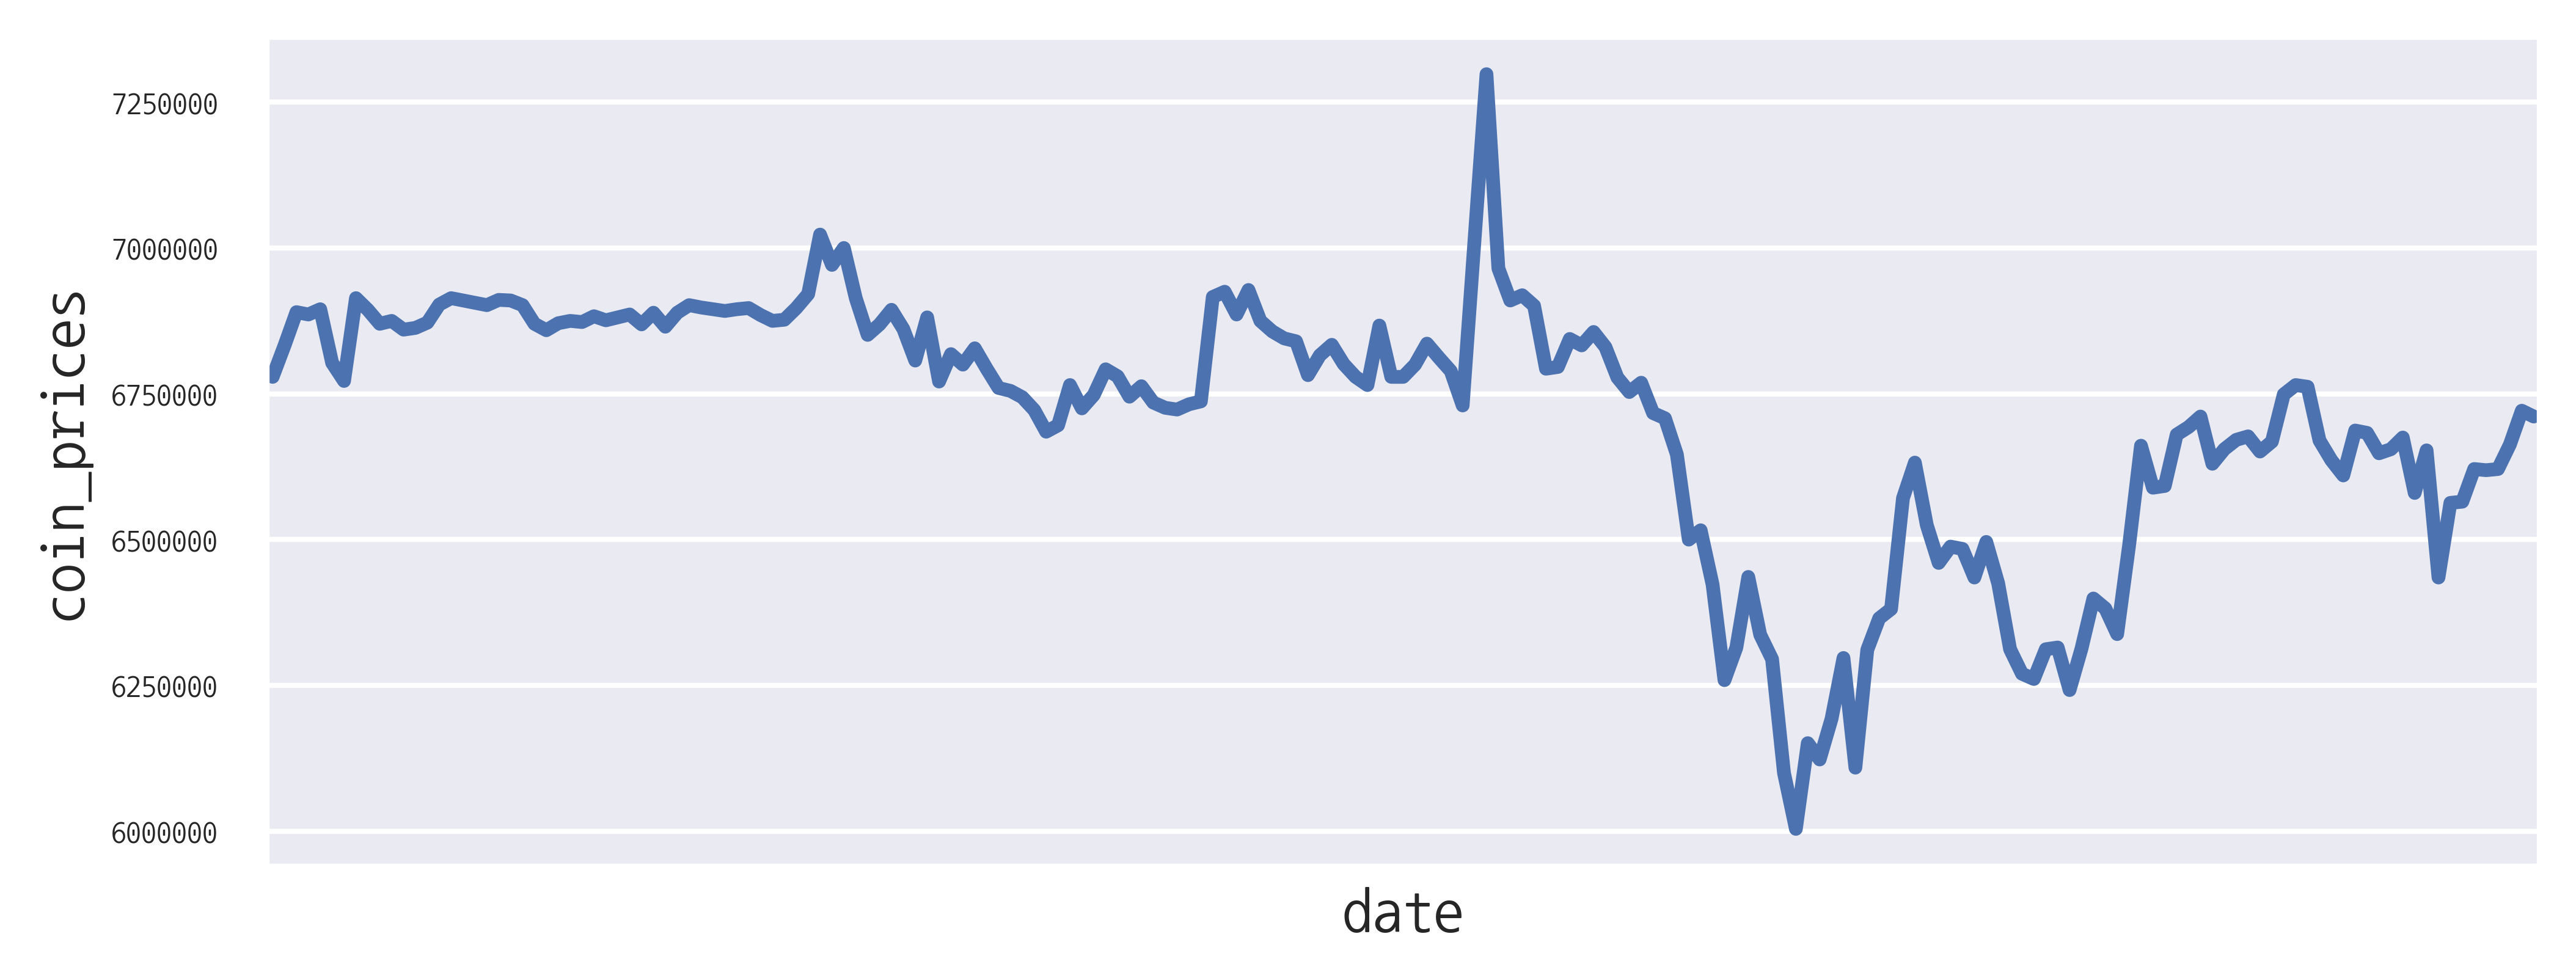

In [223]:
sns.pointplot(data=bitcoin, x='date', y='coin_prices', markers='')
plt.xticks(fontsize=6, rotation=90, ticks =[])
plt.yticks(fontsize=6)
plt.legend
plt.show()